# Projet MALAP

## Réalisé par Tong Zhao, Quentin Duchemin et Pierre Boyeau

In [1]:
import  numpy as np
import matplotlib.pyplot as plt
from tools import *
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from scipy import stats
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, scale
import pandas as pd
from mnist import MNIST
import time

In [2]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def get_usps(l,datax,datay):
    """ l : liste des chiffres a extraire"""
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =  list( zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    idx = np.random.permutation(range(len(tmpy)))
    return tmpx[idx,:],tmpy[idx]

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")
    
xusps,yusps = load_usps("datas/usps/USPS_train.txt")

## Data processing

In [3]:
def analyse_data(y, L):
    label_L, count_L = np.unique(y[:L], return_counts=True)
    label_U, count_U = np.unique(y[L:], return_counts=True)
    
    
    if np.any(label_L != label_U):
        print("Test data has unknown labels. Please re-select again.")
        return
    
    colors = np.random.rand(len(label_L), 3,1)
    plt.figure(figsize=(6, 6))
    
    for i, label in enumerate(label_L):
        plt.bar(1.5, count_L[i], width=0.3, bottom=np.sum(count_L[:i]), alpha=0.8, color=colors[i], label = str(label))
        plt.bar(3, count_U[i], width=0.3, bottom=np.sum(count_U[:i]), alpha=0.8, color=colors[i])
    
    plt.title("The paritition of dataset")
    plt.xticks([1.5, 3], ['labeled', 'unlabeled'])
    plt.grid()
    plt.legend()
    plt.show()

### USPS dataset

Load USPS data...

Data shape: 1742 * 256

Labeled num: 88

Unlabeld num: 1654


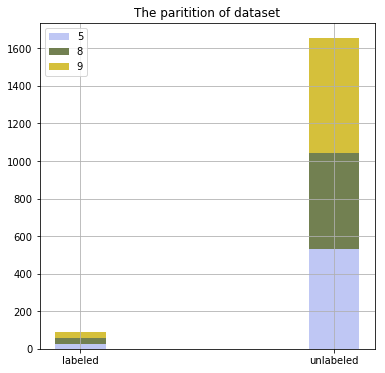

In [4]:
# Définition de la base d'apprentissage
xuspstrain,yuspstrain = get_usps([5, 8, 9],xusps,yusps)
data = xuspstrain
(n,m) = np.shape(data)

# shuffle data
idx = np.random.permutation(n)
data = data[idx]
yuspstrain = yuspstrain[idx]

# Pourcentage de la base d'apprentissage non étiquettée
percent_u = 95./100.
# nombre de données non étiquettées
U = int(percent_u * n)
# nombre de données étiquettées
L =  n-U

# étiquettes connues
labels = yuspstrain[:L]
# étiquettes à prédire
labpredire = yuspstrain[L:]

print("Load USPS data...\n")
print("Data shape: %d * %d" % data.shape)
print("\nLabeled num: %d" % L)
print("\nUnlabeld num: %d" % U)
analyse_data(yuspstrain, L)

### Mnist

In [63]:
def select_data(a, x, y):
    idx = np.in1d(y, a)
    return x[idx], y[idx]

In [64]:
mndata = MNIST('./datas/Mnist/')
xmnist, ymnist = mndata.load_training()
xmnist, ymnist = np.array(xmnist).astype(float) / 255, np.array(ymnist)

Load Mnist data...

Data shape: 3000 * 784

Labeled num: 2715

Unlabeld num: 285


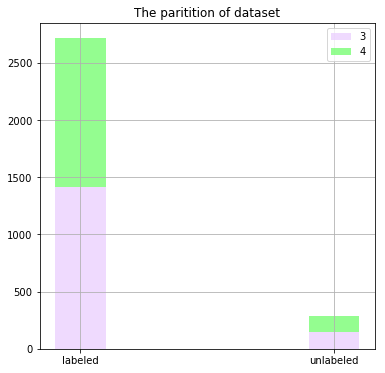

In [65]:
xmnisttrain, ymnisttrain = select_data([3, 4], xmnist, ymnist)
data = xmnisttrain
(n,m) = np.shape(data)

# shuffle data
idx = np.random.permutation(n)
data = data[idx]
ymnisttrain = ymnisttrain[idx]

n = 3000
data = data[:n]
ymnisttrain = ymnisttrain[:n]

# Pourcentage de la base d'apprentissage non étiquettée
percent_u = 95./1000.
# nombre de données non étiquettées
U = int(percent_u * n)
# nombre de données étiquettées
L =  n-U

# étiquettes connues
labels = ymnisttrain[:L]
# étiquettes à prédire
labpredire = ymnisttrain[L:]

print("Load Mnist data...\n")
print("Data shape: %d * %d" % data.shape)
print("\nLabeled num: %d" % L)
print("\nUnlabeld num: %d" % U)
analyse_data(ymnisttrain, L)

### Spambase

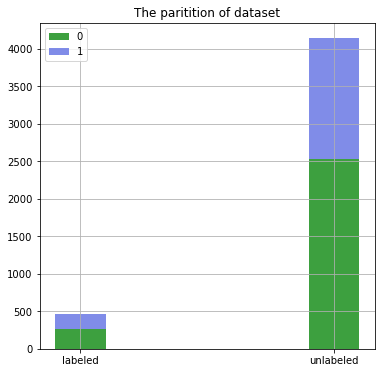

Data shape: 4601 * 57

Labeled num: 461

Unlabeld num: 4140


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
4302,0.0,0.82,0.00,0.0,0.00,0.0,0.00,0.0,0.0,1.24,...,0.0,4.149,0.000,0.0,0.070,0.000,0.562,7.416,43,356
4021,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000,0.170,0.0,0.000,0.000,0.000,1.373,11,169
3591,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000,0.000,0.0,0.000,0.000,0.000,1.000,1,5
3957,0.0,0.00,0.00,0.0,2.38,0.0,0.00,0.0,0.0,0.00,...,0.0,0.000,0.000,0.0,0.000,0.000,0.000,2.111,6,19
1793,0.0,0.00,1.47,0.0,0.00,1.1,0.36,0.0,0.0,0.00,...,0.0,0.000,0.123,0.0,0.433,0.928,0.185,3.000,33,177


In [62]:
columns = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove',
           'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people',
           'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you',
           'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl',
           'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data',
           'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct',
           'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table',
           'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#',
           'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total', 'is_spam']

df = pd.read_csv('spambase.data', names=columns)
df = shuffle(df)

lbl = df.pop('is_spam').as_matrix()
data = df.as_matrix().copy()


# Normalisation de la base de données
#min_max_scaler = MinMaxScaler()
#data =  min_max_scaler.fit_transform(data)
data = scale(data)

n, m = np.shape(data)
# Pourcentage de la base d'apprentissage non étiquettée
percent_u = 900/1000.
# nombre de données non étiquettées
U = int(percent_u * n)
# nombre de données étiquettées
L =  n-U

# étiquettes connues
labels = lbl[:L]
# étiquettes à prédire
labpredire = lbl[L:]

analyse_data(lbl, L)


print("Data shape: %d * %d" % data.shape)
print("\nLabeled num: %d" % L)
print("\nUnlabeld num: %d" % U)
df.head()

In [31]:
# Vérification des données
print(np.min(data, axis=0))
print(np.max(data, axis=0))

[-0.34243371 -0.16507191 -0.55676058 -0.04689958 -0.4643144  -0.35026618
 -0.29179389 -0.26256156 -0.32330236 -0.37136439 -0.29685953 -0.62871259
 -0.31205521 -0.17492717 -0.19011441 -0.3013776  -0.32113541 -0.34787592
 -0.93624235 -0.16789311 -0.67441898 -0.11817151 -0.2902092  -0.21299439
 -0.32881467 -0.29923993 -0.22789481 -0.23183016 -0.16673145 -0.22523952
 -0.16053931 -0.14321202 -0.17492026 -0.14521515 -0.19806739 -0.24213022
 -0.32345561 -0.05983624 -0.18091134 -0.18530385 -0.12090468 -0.17259996
 -0.20599311 -0.12734332 -0.29777621 -0.19738748 -0.0713879  -0.11154623
 -0.15845336 -0.51430655 -0.15519768 -0.32991229 -0.30835494 -0.1030484
 -0.13211609 -0.26259945 -0.46560727]
[ 14.52699812  10.90096453   9.56051863  30.641278    14.40690791
  21.12570858  18.2826109   27.44124901  18.55778944  27.82843975
  12.65453114  10.59453005  18.12629386  29.66269031  16.84906236
  23.92043737  15.75968961  16.76868255   9.62542599  35.49934298
   8.57867625  16.55427828  15.27017816  2

In [32]:
print(np.shape(data))
print(np.shape(labels))

(4601, 57)
(461,)


## Baseline 1 - K plus proche voisins 

In [66]:
class KNN:
    
    def __init__(self, k):
        self.k = k
        
    def fit(self, data, labels):
        self.N = data.shape[0]
        L = labels.shape[0]
        
        # calculate distance
        self.W = cosine_distances(data[L:], data[:L])
        self.labels = labels
        
    def predict(self):
        
        idx = np.argsort(self.W, axis = 1)[:, :self.k]
        bag = self.labels[idx]
        predict, _ = stats.mode(bag, axis = 1)
        
        return predict.reshape((-1))
    
    def score(self, labels):
        return (self.predict()==labels).mean()

In [67]:
M = KNN(1)
M.fit(data,labels)
print("The score of Diffusion by knn is %f" % M.score(labpredire))

The score of Diffusion by knn is 1.000000


In [68]:
def test_knn(data, labels, labpredire):
    lk = range(2, 30, 2)
    lscore = []
    
    for k in lk:
        M = KNN(k)
        M.fit(data, labels)
        lscore.append(M.score(labpredire))
        
    print("The best k: %d" % lk[np.argmax(np.array(lscore))])
    print("The best score: %f" % np.max(np.array(lscore)))
    plt.figure(figsize=(6, 6))
    plt.plot(lk, lscore)
    plt.title('The knn score influenced by k')
    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.grid()
    plt.show()

The best k: 2
The best score: 0.996491


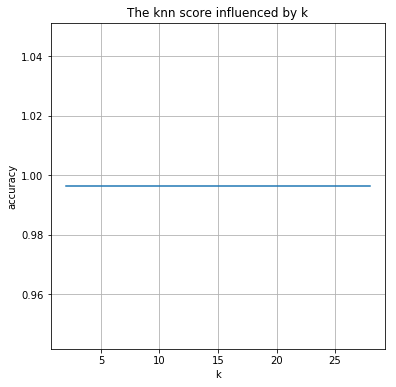

In [69]:
test_knn(data, labels, labpredire)

## Baseline 2 - SVM

In [70]:
clf = SVC(C=5, gamma=0.01)
clf.fit(data[:L], labels)
print("The score of SVM is %f" % (clf.score(data[L:], labpredire)))

The score of SVM is 0.992982


In [71]:
def test_svm(data, y, L):
    lc = np.arange(1, 5, 0.5)
    lscore = []
    
    for c in lc:
        print (c)
        clf = SVC(C=c, gamma=0.01)
        clf.fit(data[:L], y[:L])
        lscore.append(clf.score(data[L:], y[L:]))

    print("The best c: %f" % lc[np.argmax(np.array(lscore))])
    print("The best score: %f" % np.max(np.array(lscore)))
    plt.figure(figsize=(6, 6))
    plt.plot(lc, lscore)
    plt.title('The SVM score influenced by c')
    plt.xlabel('c')
    plt.ylabel('accuracy')
    plt.grid()
    plt.show()

1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
The best c: 1.000000
The best score: 0.996491


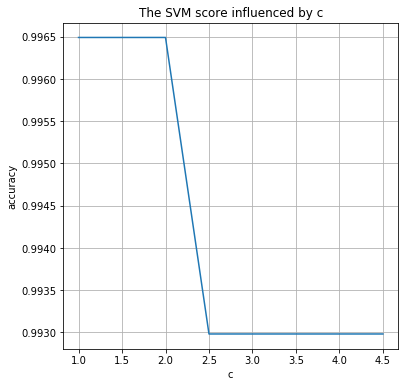

In [72]:
test_svm(data, ymnisttrain, L)
#test_svm(data, lbl, L)

## 1. Classification using simply threshold

$$ f_u = (D_{uu} - W_{uu})^{-1} W_{ul} f_l$$

In [73]:
class DiffusionTRESH:
        
    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)

        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        fu = np.dot(np.dot(np.linalg.pinv(self.D[self.L:,self.L:] - self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
            
    def fit(self, data, labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(np.shape(data)[1])])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
        
    def score(self, labels):
        return (self.predict()==labels).mean()


In [74]:
M = DiffusionTRESH()
M.fit(data,labels)
print("The score of Diffusion by threshold is %f" % M.score(labpredire))

The score of Diffusion by threshold is 0.996491



## 2. Incorporation of Class Prior : CMN with weights fixed by advance

In [75]:
class DiffusionCMN:

    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        
        # calculate fu
        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        desirable_proportions = y.sum(0) + 1
        fu = np.dot(np.dot(np.linalg.pinv(self.D[self.L:,self.L:]-self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
        fu = fu * (desirable_proportions / fu.sum(0))

        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
            
    def fit(self,data,labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(np.shape(data)[1])])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
    def score(self,labels):
        return (self.predict()==labels).mean()

In [76]:
M = DiffusionCMN()
M.fit(data,labels)
print("The score of Diffusion by class prior is %f" % M.score(labpredire))

The score of Diffusion by class prior is 0.996491


## 3. Incorporating External Classifiers - SVM

## 3.1 TRESH + SVM

In [77]:
class DiffusionTRESHSVM:

    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        
        # calculate fu
        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        fu = np.dot(np.dot(np.linalg.inv(self.D[self.L:,self.L:]-self.W[self.L:,self.L:]),self.W[self.L:,:self.L]),y)
        fu = fu * self.hu
        
        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
            
    def fit(self,data,labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(np.shape(data)[1])])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
        # train svm
        clf = SVC(C=2, probability = True)
        clf.fit(data[:self.L], labels)
        self.hu = clf.predict_proba(data[self.L:])
        
    def score(self,labels):
        return (self.predict()==labels).mean()

In [78]:
M = DiffusionTRESHSVM()
M.fit(data,labels)
print("The score of Diffusion by class prior is %f" % M.score(labpredire))

The score of Diffusion by class prior is 0.996491


## 3.2 Non fonctionnel : essai car doute sur la formule utilisée dans TRESHSVM

In [79]:
class DiffusionCMNSVM:

    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        
        # calculate fu
        y = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        P =  np.dot(np.linalg.inv(self.D),self.W)
        fu = np.dot(np.linalg.inv(np.eye(P.shape[0]-self.L)-(1-self.hu) * P[self.L:,self.L:]), np.dot((1-self.hu)*P[self.L:,:self.L], y) + np.dot(self.hu , self.pred_svm)) 
        
        prediction = set_labels[np.argmax(fu, axis = 1)]
        return prediction          
         
            
    def fit(self,data,labels):
        self.labels = labels
        self.L = labels.shape[0]
        sigmas = np.array([2.5 for i in range(np.shape(data)[1])])
        
        # calculate W
        data_n = data / sigmas
        self.W = np.exp(-euclidean_distances(data_n)**2)
        
        # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
        
        # train svm
        clf = SVC(C=2, probability = True)
        clf.fit(data[:self.L], labels)
        self.hu = clf.predict_proba(data[L:])
        self.pred_svm = clf.predict(data[L:])
        print(np.shape(self.hu))
        print(np.shape(self.pred_svm))
        print(labels)

        
    def score(self,labels):
        return (self.predict()==labels).mean()

In [80]:
M = DiffusionCMNSVM()
M.fit(data,labels)
print("The score of Diffusion by class prior is %f" % M.score(labpredire))

(285, 2)
(285,)
[3 3 3 ..., 4 4 3]


ValueError: operands could not be broadcast together with shapes (285,2) (285,285) 

# TESTS

In [ ]:

# Test sur les données USPS
xuspstrain,yuspstrain = load_usps("datas/usps/USPS_train.txt")
xtrain,ytrain = get_usps([0,1,2,3,4,5,6,7,8,9],xuspstrain,yuspstrain)
(n,m) = np.shape(xtrain)

# shuffle data
idx = np.random.permutation(n)
xtrain = xtrain[idx]
ytrain = ytrain[idx]
xtrain = xtrain[:1000,:]
ytrain = ytrain[:1000]
(n,m) = np.shape(xtrain)

nb_tests = 10
# Pourcentage de la base d'apprentissage non étiquettée
list_percent_u = [((98-50)/100.0)*(float(i)/nb_tests) + 50/100.0 for i in range(nb_tests)]
score_KNN,score_thresh,score_CMN,score_threshsvm = [],[],[], []

for percent_u in list_percent_u:
    #nombre de données non étiquettées
    U = int(percent_u * n)
    # nombre de données étiquettées
    L =  n-U
    # étiquettes connues
    labels = ytrain[:L]
    # étiquettes à prédire
    labpredire = ytrain[L:]
    M = KNN(10)
    M.fit(xtrain,labels)
    score_KNN.append(M.score(labpredire))
    M = DiffusionTRESH()
    M.fit(xtrain,labels)
    score_thresh.append(M.score(labpredire))
    M = DiffusionCMN()
    M.fit(xtrain,labels)
    score_CMN.append(M.score(labpredire))
    M = DiffusionTRESHSVM()
    M.fit(xtrain,labels)
    score_threshsvm.append(M.score(labpredire))
plt.figure(figsize=(20, 8))
plt.plot(list_percent_u,score_KNN,label = "KNN")
plt.plot(list_percent_u,score_thresh,label = "TRESH")
plt.plot(list_percent_u,score_CMN,label = "CMN")
plt.plot(list_percent_u,score_threshsvm,label = "THRESH + SVM")
plt.title("Resultat des predictions pour diverses methodes en fonction du pourcentage de donnees non etiquettees")
plt.ylabel("Score obtenu")
plt.xlabel("Pourcentage de donnees non etiquettees")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

# 4. Learning W

### Binary classification

In [114]:
class DiffusionLEARN:
    
    def __init__(self, eps=0.01, lr = 0.1):        
        self.eps = eps
        self.lr = lr

    def oracle(self, sgm, max_iter):
        
        self.h_histo = [1000]
        self.dh_histo = None
        
        for i in range(max_iter):
            # calculate W
            data_sgm = self.data / sgm
            self.W = np.exp(-euclidean_distances(data_sgm) ** 2)
            # calculate D
            diago = np.sum(self.W,axis=1)
            self.D = np.diag(diago)
            # calculate P
            P = np.dot(np.linalg.inv(self.D), self.W)
            Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
            # calculate fu
            fu = np.dot(np.dot(np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:]), Ps[self.L:, :self.L]), self.fl)
            # calculate H
            self.h_histo.append(self.H(fu))
            # if this is the right direction
            if self.h_histo[-1] <= self.h_histo[-2]:
                # calculate the gradient of H
                dh = self.gradH(fu, P, sgm)
                self.dh_histo = np.hstack((self.dh_histo, dh)) if self.dh_histo != None else dh
                if np.all(np.abs(dh) < 1e-3) or self.lr < 1e-8:
                    break
                else:
                    sgm = sgm - self.lr * dh.reshape((1, -1))
            else:
                self.lr = self.lr / 5
                
        self.sigmas = sgm
        self.fu = fu

    def H(self, fu):
        return - (fu * np.log(fu)).sum() / self.U

    def gradH(self, fu, P, sgm):
        
        Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
        grad_h_sgm = []
        for i in range(256):
            Xi = np.tile(self.data[:, i], (self.U + self.L, 1))
            dw_sgm = 2 * self.W * ((Xi.T - Xi) ** 2) / (sgm[0, i] ** 3)
            # formule 14
            sum_dw = dw_sgm.sum(1).reshape((-1, 1))
            sum_w = self.W.sum(1).reshape((-1, 1))
            dps_sgm = (1 - self.eps) * (dw_sgm - P * sum_dw) / sum_w
            # formule 13
            dfu_sgm_1 = np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:])
            dfu_sgm_2 = dps_sgm[self.L:, self.L:].dot(fu) + dps_sgm[self.L:, :self.L].dot(self.fl)
            dfu_sgm = np.dot(dfu_sgm_1, dfu_sgm_2)
            # formule 12
            dh_sgm = (fu[:,0] / fu[:, 1] * dfu_sgm[:, 1]).sum() / self.U
            # save result
            grad_h_sgm.append(dh_sgm)
            
        return np.array(grad_h_sgm).reshape((-1, 1))

    def fit(self, data, labels):
        self.labels = labels
        self.data = data
        self.L = labels.shape[0]
        self.U = data.shape[0] - self.L
        self.D = data.shape[1]
        
    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        # calculate fl
        self.fl = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        sgm = np.array([2.5 for i in range(m)]).reshape((1, -1))
        # optimisation
        self.oracle(sgm, 5)
        # predict
        prediction = set_labels[np.argmax(self.fu, axis = 1)]
        return prediction          
    
    def score(self, labels):
        return (self.predict()==labels).mean()

In [119]:
M = DiffusionLEARN()
M.fit(data,labels)
print("The score of Diffusion by learning w is %f" % M.score(labpredire))

ValueError: operands could not be broadcast together with shapes (4601,57) (1,784) 

### Multi-class

In [120]:
from multiprocessing import Pool


"""Ensemble des mesures prises:
Analyse des parties lourdes en temps de calcul du code.
Elles correspondent surtout au calcul de P ainsi qu'au calcul de gradient de H
Optimisation de gradient_h ==> Descente STOCHASTIQUE + optimisation de code
"""

class DiffusionLEARN2:
    
    def __init__(self, eps=0.01, lr = 0.1, max_iter=5):        
        self.eps = eps
        self.lr = lr
        self.max_iter = max_iter

    def oracle(self, sgm, max_iter):
        
        self.h_histo = [1000]
        self.dh_histo = None
        
        for i in range(max_iter):
            print("\n Iteration :", i)
            # calculate W
            print("Computing W")
            data_sgm = self.data / sgm
            self.W = np.exp(-euclidean_distances(data_sgm) ** 2)
            
            # calculate D
            print("Computing D")
            diago = np.sum(self.W,axis=1)
            self.D = np.diag(diago)
            
            # calculate P
            print("Computing P")
            P = np.dot(np.linalg.inv(self.D), self.W)
            Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
            # calculate fu
            print("Computing fu")
            fu = np.dot(np.dot(np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:]), Ps[self.L:, :self.L]), self.fl)


            # calculate H
            print("Gradient descent")
            self.h_histo.append(self.H(fu))
            # if this is the right direction
            if self.h_histo[-1] <= self.h_histo[-2]:
                # calculate the gradient of H
                dh = self.gradH(fu, P, sgm)
                self.dh_histo = np.hstack((self.dh_histo, dh)) if self.dh_histo is not None else dh
                
                
                # PASSAGE A COMPRENDRE
#                 if np.all(np.abs(dh) < 1e-3) or self.lr < 1e-8:
#                     pass
                if np.all(np.abs(dh) < 1e-3):
                    pass
                
                
                else:
                    sgm = sgm - self.lr * dh.reshape((1, -1))
            else:
                self.lr = self.lr / 5
        self.sigmas = sgm
        self.fu = fu

    def H(self, fu):
        return - (fu * np.log(fu)).sum() / self.U

    def myfunc(self, idx, fu, P, sigma, dfu_sgm_1):
        Xi = np.tile(self.data[:, idx], (self.U + self.L, 1))
        dw_sgm = 2 * self.W * ((Xi.T - Xi) ** 2) / (sigma[0, idx] ** 3)
        # formule 14
        sum_dw = dw_sgm.sum(1).reshape((-1, 1))
        sum_w = self.W.sum(1).reshape((-1, 1))
        dps_sgm = (1 - self.eps) * (dw_sgm - P * sum_dw) / sum_w
        # formule 13
        dfu_sgm_2 = dps_sgm[self.L:, self.L:].dot(fu) + dps_sgm[self.L:, :self.L].dot(self.fl)
        dfu_sgm = np.dot(dfu_sgm_1, dfu_sgm_2)
        # formule 12
        dh_sgm = -((np.log(fu) + 1) * dfu_sgm).sum() / self.U
        # save result
        return dh_sgm
    
    def gradH(self, fu, P, sgm):
        
        Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
        grad_h_sgm = []
        dfu_sgm_1 = np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:])

        for i in range(self.d):
            Xi = np.tile(self.data[:, i], (self.U + self.L, 1))
            dw_sgm = 2 * self.W * ((Xi.T - Xi) ** 2) / (sgm[0, i] ** 3)
            # formule 14
            sum_dw = dw_sgm.sum(1).reshape((-1, 1))
            sum_w = self.W.sum(1).reshape((-1, 1))
            dps_sgm = (1 - self.eps) * (dw_sgm - P * sum_dw) / sum_w
            # formule 13
            dfu_sgm_2 = dps_sgm[self.L:, self.L:].dot(fu) + dps_sgm[self.L:, :self.L].dot(self.fl)
            dfu_sgm = np.dot(dfu_sgm_1, dfu_sgm_2)
            # formule 12
            dh_sgm = -((np.log(fu) + 1) * dfu_sgm).sum() / self.U
            # save result
            grad_h_sgm.append(dh_sgm)
            
        return np.array(grad_h_sgm).reshape((-1, 1))

    def fit(self, data, labels):
        self.labels = labels
        self.data = data
        self.L = labels.shape[0]
        self.U = data.shape[0] - self.L
        self.d = data.shape[1]
        
    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        # calculate fl
        self.fl = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        sgm = np.array([3.5 for i in range(m)]).reshape((1, -1))
        # optimisation
        self.oracle(sgm, self.max_iter)
        # predict
        prediction = set_labels[np.argmax(self.fu, axis = 1)]
        return prediction          
    
    def score(self, labels):
        return (self.predict()==labels).mean()

In [ ]:
M = DiffusionLEARN2(lr=1, max_iter=10)
M.fit(data,labels)
print("The score of Diffusion by learning w is %f" % M.score(labpredire))


 Iteration : 0
Computing W
Computing D
Computing P
Computing fu
Gradient descent


In [ ]:
class DiffusionLEARN_ONE_SGM:
    
    def __init__(self, eps=0.01, lr = 0.1):        
        self.eps = eps
        self.lr = lr

    def oracle(self, sgm, max_iter):
        
        self.h_histo = [1000]
        self.dh_histo = None
        self.ls_sgm = []
        
        for i in range(max_iter):
            # calculate W
            data_sgm = self.data / sgm
            self.W = np.exp(-euclidean_distances(data_sgm) ** 2)
            # calculate D
            diago = np.sum(self.W,axis=1)
            self.D = np.diag(diago)
            # calculate P
            P = np.dot(np.linalg.inv(self.D), self.W)
            
            Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
            # calculate fu
            fu = np.dot(np.dot(np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:]), Ps[self.L:, :self.L]), self.fl)
            # calculate H
            self.h_histo.append(self.H(fu))
            self.ls_sgm.append(sgm)
            # if this is the right direction
            # calculate the gradient of H
            dh = self.gradH(fu, P, sgm)
            self.dh_histo = np.hstack((self.dh_histo, dh)) if self.dh_histo != None else dh
            sgm = sgm - self.lr * dh.reshape((1, -1))

        
        self.sigmas = sgm
        self.fu = fu
        
    def H(self, fu):
        return - (fu * np.log(fu)).sum() / self.U

    def gradH(self, fu, P, sgm):
        
        Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
        grad_h_sgm = []
        
        dw_sgm = 2 * self.W * euclidean_distances(self.data) ** 2 / (sgm ** 3)
        # formule 14
        sum_dw = dw_sgm.sum(1).reshape((-1, 1))
        sum_w = self.W.sum(1).reshape((-1, 1))
        dps_sgm = (1 - self.eps) * (dw_sgm - P * sum_dw) / sum_w
        # formule 13
        dfu_sgm_1 = np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:])
        dfu_sgm_2 = dps_sgm[self.L:, self.L:].dot(fu) + dps_sgm[self.L:, :self.L].dot(self.fl)
        dfu_sgm = np.dot(dfu_sgm_1, dfu_sgm_2)
        # formule 12
        dh_sgm = ((fu[:,0] / fu[:, 1]) * dfu_sgm[:, 1]).sum() / self.U
        # save result
        grad_h_sgm.append(dh_sgm)
            
        return np.array(grad_h_sgm).reshape((-1, 1))

    def fit(self, data, labels):
        self.labels = labels
        self.data = data
        self.L = labels.shape[0]
        self.U = data.shape[0] - self.L
        self.d = data.shape[1]
        
    def predict(self,sgm):
        # record label
        set_labels = np.unique(self.labels)
        # calculate fl
        self.fl = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        # optimisation
        self.oracle(sgm, 5000)
        # predict
        prediction = set_labels[np.argmax(self.fu, axis = 1)]
        return prediction
    
    def entropie_sgm(self,sgm): 
        # record label
        set_labels = np.unique(self.labels)
        # calculate fl
        self.fl = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        # Calculate fu
        data_sgm = self.data / sgm
        self.W = np.exp(-euclidean_distances(data_sgm) ** 2)
            # calculate D
        diago = np.sum(self.W,axis=1)
        self.D = np.diag(diago)
            # calculate P
        P = np.dot(np.linalg.inv(self.D), self.W)
            # calculate fu
        Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
            # calculate fu
        fu = np.dot(np.dot(np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:]), Ps[self.L:, :self.L]), self.fl)
        # calculate entropy
        return self.H(fu)  
    
    def score(self, sgm,labels):
        return (self.predict(sgm)==labels).mean()

In [ ]:
X = []
label = []
for i in range(-3,4):
    for j in range(-2,5):
        if j==1 :
            if i==0:
                X.append([0,0.66])
                X.append([0,1.33])
        else:
            X.append([i,j])
        if j>1:
            label.append(1)
        elif j<1:
            label.append(-1)
        elif i==0:
            label.append(-1)
            label.append(1)
X = np.array(X)
label = np.array(label)
for i in range(0,2):
    X[40,i],X[0,i] = X[0,i],X[40,i]
    X[3,i],X[1,i] = X[1,i],X[3,i]
label[1],label[3] = label[3],label[1]
label[0],label[40] = label[40],label[0]


ind1 = np.where(label ==1)[0]
indm1 = np.where(label ==-1)[0]


plt.scatter(X[ind1,0],X[ind1,1],marker='+')
plt.scatter(X[indm1,0],X[indm1,1],marker='o')
plt.scatter(X[0,0],X[0,1],color='r',marker='o')
plt.scatter(X[1,0],X[1,1],color='r',marker='+')

plt.show()
labels = label[:2]
labpredire = label[2:]

ls_eps = [10**(-1),10**(-2),10**(-3),0]
couleurs = ['r','b','g','y']
for k in range(4):
    l_h = np.array([])
    l_s = np.array([])
    epsilon = ls_eps[k]
    M = DiffusionLEARN_ONE_SGM(eps = epsilon,lr=0.1)
    M.fit(X,labels)
    for sgm in [1.4]:
        s = M.score(sgm,labpredire)
        l_h = np.concatenate((l_h,M.h_histo[1:]))
        l_s = np.concatenate((l_s,M.ls_sgm))
    plt.plot(l_s,l_h,color=couleurs[k],label='epsilon=' + str(epsilon))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
entropie_eps= [[] for k in range(3)]
values_sgm = np.array([i/10 for i in range(2,15)])
for k in range(3):
    epsilon = 10**(-k-1)
    M = DiffusionLEARN_ONE_SGM(eps = epsilon)
    M.fit(X,labels)
    for sig in values_sgm:
        entropie_eps[k].append(M.entropie_sgm(sig))

plt.plot(values_sgm,entropie_eps[0],color='r',label='eps = 0.1')
plt.plot(values_sgm,entropie_eps[1],color='b',label='eps = 0.01')
plt.plot(values_sgm,entropie_eps[2],color='g',label='eps = 0.001')
plt.title("Influence de sigma")
plt.ylabel("Entropie")
plt.xlabel("sigma")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Tentative d'accélération en utilisant les séries de Taylor

In [ ]:
class Diffusiongrid():
        def __init__(self, eps=0.01, lr = 0.1, max_iter=5):        
        self.eps = eps
        self.lr = lr
        self.max_iter = max_iter

    def oracle(self, sgm, max_iter):
        
        self.h_histo = [1000]
        self.dh_histo = None
        
        for i in range(max_iter):
            print("\n Iteration :", i)
            # calculate W
            print("Computing W")
            data_sgm = self.data / sgm
            self.W = np.exp(-euclidean_distances(data_sgm) ** 2)
            
            # calculate D
            print("Computing D")
            diago = np.sum(self.W,axis=1)
            self.D = np.diag(diago)
            
            # calculate P
            print("Computing P")
            P = np.dot(np.linalg.inv(self.D), self.W)
            Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
            # calculate fu
            print("Computing fu")
            fu = np.dot(np.dot(np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:]), Ps[self.L:, :self.L]), self.fl)


            # calculate H
            print("Gradient descent")
            self.h_histo.append(self.H(fu))
            # if this is the right direction
            if self.h_histo[-1] <= self.h_histo[-2]:
                # calculate the gradient of H
                dh = self.gradH(fu, P, sgm)
                self.dh_histo = np.hstack((self.dh_histo, dh)) if self.dh_histo is not None else dh
                
                
                # PASSAGE A COMPRENDRE
#                 if np.all(np.abs(dh) < 1e-3) or self.lr < 1e-8:
#                     pass
                if np.all(np.abs(dh) < 1e-3):
                    pass
                
                
                else:
                    sgm = sgm - self.lr * dh.reshape((1, -1))
            else:
                self.lr = self.lr / 5
        self.sigmas = sgm
        self.fu = fu

    def H(self, fu):
        return - (fu * np.log(fu)).sum() / self.U

    def gradH(self, fu, P, sgm):
        
        Ps = (1 - self.eps) * P + self.eps / (self.L + self.U)
        grad_h_sgm = np.zeros((self.d, 1))
        dfu_sgm_1 = np.linalg.inv(np.eye(self.U) - Ps[self.L:, self.L:]) # A calculer ici car inutile de recalculer.
        
        #sample = [np.random.randint(0, self.d) for j in range(10)]
        for i in range(self.d):
            Xi = np.tile(self.data[:, i], (self.U + self.L, 1))
            dw_sgm = 2 * self.W * ((Xi.T - Xi) ** 2) / (sgm[0, i] ** 3)
            # formule 14
            sum_dw = dw_sgm.sum(1).reshape((-1, 1))
            sum_w = self.W.sum(1).reshape((-1, 1))
            dps_sgm = (1 - self.eps) * (dw_sgm - P * sum_dw) / sum_w
            # formule 13
            dfu_sgm_2 = dps_sgm[self.L:, self.L:].dot(fu) + dps_sgm[self.L:, :self.L].dot(self.fl)
            dfu_sgm = np.dot(dfu_sgm_1, dfu_sgm_2)
            # formule 12
            dh_sgm = -((np.log(fu) + 1) * dfu_sgm).sum() / self.U
            # save result
            grad_h_sgm[i] = dh_sgm
            
        return np.array(grad_h_sgm).reshape((-1, 1))

    def fit(self, data, labels):
        self.labels = labels
        self.data = data
        self.L = labels.shape[0]
        self.U = data.shape[0] - self.L
        self.d = data.shape[1]
        
    def predict(self):
        
        # record label
        set_labels = np.unique(self.labels)
        # calculate fl
        self.fl = (np.tile(self.labels.reshape((-1, 1)), (1, set_labels.shape[0])) == set_labels).astype(int)
        sgm = np.array([3.5 for i in range(m)]).reshape((1, -1))
        # optimisation
        self.oracle(sgm, self.max_iter)
        # predict
        prediction = set_labels[np.argmax(self.fu, axis = 1)]
        return prediction          
    
    def score(self, labels):
        return (self.predict()==labels).mean()
    